In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: Remove sensitive features

# Get the data

In [35]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [36]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [41]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.54514,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,0.484365,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.484365,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.484365,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.54514,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.54514,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.484365,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,0.54514,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.484365,0.331967,0.0,0.659453,0.522612


# Predict

In [42]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

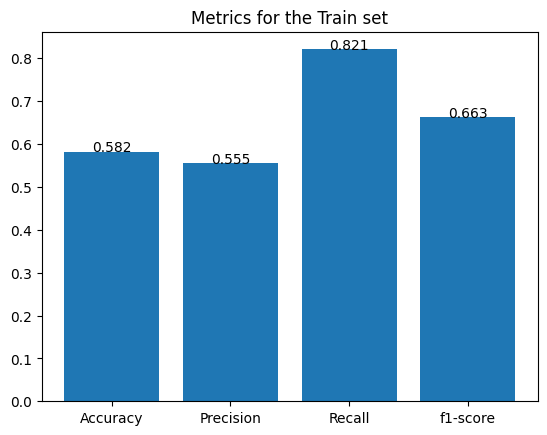

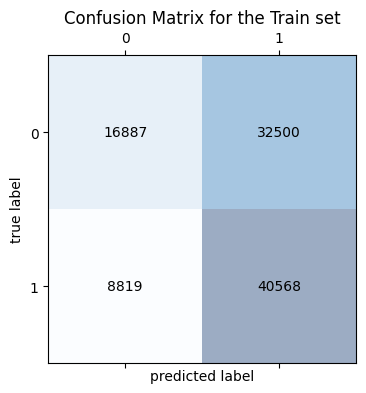

In [43]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

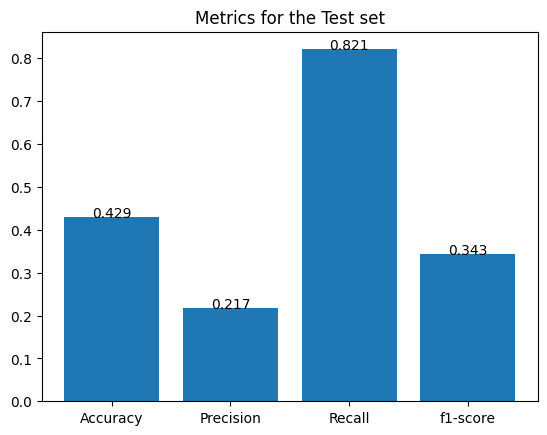

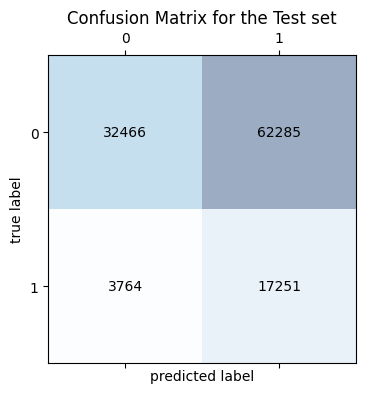

In [44]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

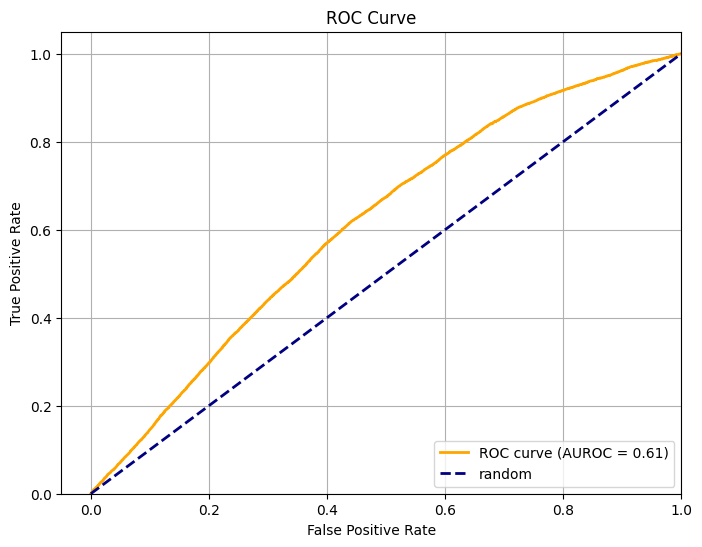

In [45]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [46]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.2168954938644136)

In [47]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.21951058528455686, 'Black': 0.22812311406155703, 'Asian': 0.18968169447402675, 'Mixed': 0.25113464447806355, 'Other': 0.18815104166666666}
Num problematic departments: 22
Num good departments: 11
avg diff: 0.1121465318099966


In [48]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.22260141384304336, 'Female': 0.17670807453416149, 'Other': 0.145985401459854}
Num problematic departments: 20
Num good departments: 15
avg diff: 0.08824064573678767


In [49]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.22269599767419324, '10-17': 0.17132473825387212, '18-24': 0.257116240554808, 'over 34': 0.175779756377342, 'under 10': 0.09803921568627451}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.1310958695198134


# Hypothesis 2: Remove stations with highest avg difference from training data

# Get the data

In [13]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

# df_clean = df_clean[(df_clean["station"].isin(['kent','durham','city-of-london','west-mercia','cheshire','derbyshire','btp','northumbria','cleveland','warwickshire']) & 
#           (df_clean['Gender'] != 'Other') &
#           (df_clean['Age range'] != 'under 10') &
#           (df_clean['Officer-defined ethnicity'] != 'Mixed'))].copy()

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [14]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']

    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('group_age_range', Group_Age_Range()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('group_ethnicity', Group_Ethnicity()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('imputer_2', SimpleImputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [15]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Age range', 'Type', 'Gender', 'Officer-defined ethnicity', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Age range,Type,Gender,Officer-defined ethnicity,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,1.0,0.913043,0.666667,0.333333,0.561424,0.503792,0.500659,0.551858,0.0,0.464501,0.537642
1,0.333333,1.0,0.043478,1.0,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.471719,0.529218
2,0.333333,1.0,0.956522,0.166667,0.666667,0.561424,0.503792,0.500659,0.551858,0.0,0.163055,0.988309
3,1.0,1.0,0.478261,0.5,0.0,0.561424,0.503792,0.500659,0.551858,0.0,0.174439,0.9017
4,0.0,0.0,0.956522,0.0,1.0,0.469699,0.503792,0.500659,0.335389,0.0,0.459833,0.540817
...,...,...,...,...,...,...,...,...,...,...,...,...
51897,0.0,0.0,0.391304,0.666667,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.462402,0.538168
51898,1.0,1.0,0.434783,0.0,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.371099,0.558076
51899,0.333333,1.0,0.043478,0.5,0.666667,0.561424,0.503792,0.500659,0.551858,0.0,0.063275,0.41232
51900,1.0,1.0,0.217391,0.333333,1.0,0.561424,0.503792,0.500659,0.551858,0.0,0.464807,0.543106


# Predict

In [16]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

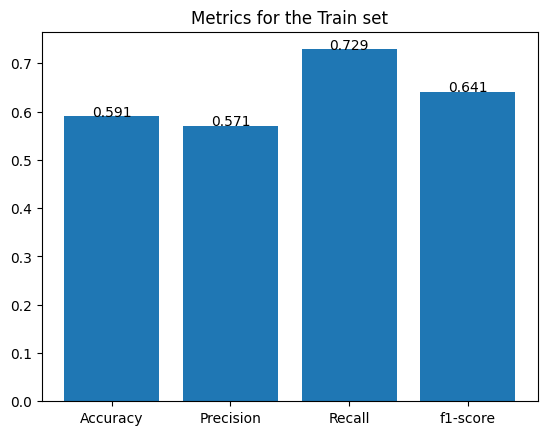

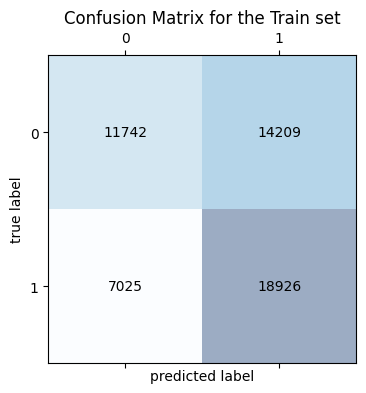

In [17]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

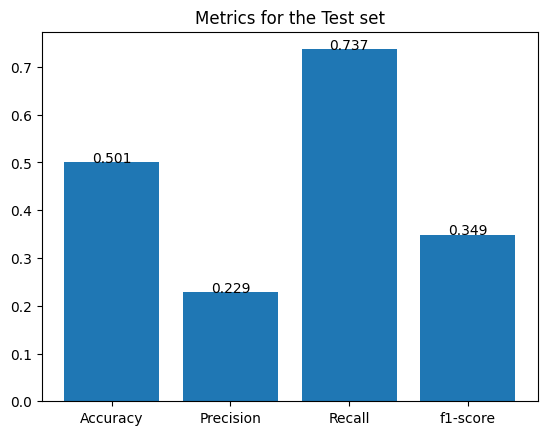

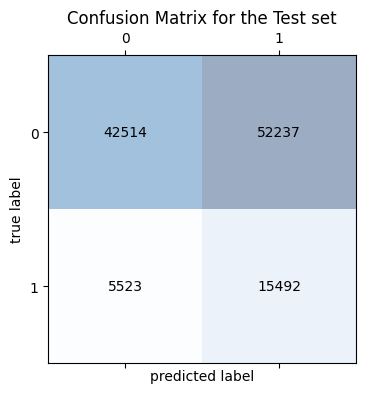

In [18]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

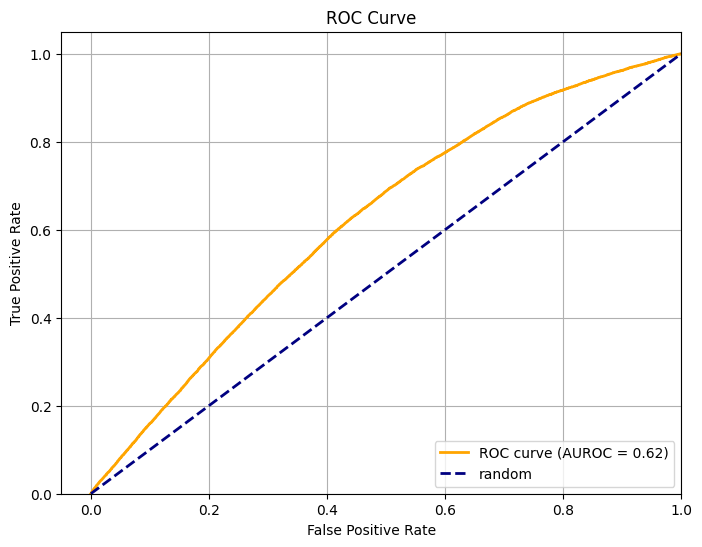

In [19]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [20]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.2287351060845428)

In [21]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    display(problematic_departments)
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.23223716501423383, 'Black': 0.2321635171615889, 'Asian': 0.20361668802506053, 'Mixed': 0.24958949096880131, 'Other': 0.19884309472161968}
Num problematic departments: 23
Num good departments: 10
avg diff: 0.11782061022209807


[('south-yorkshire',
  0.08056407912776653,
  {'White': 0.15831578947368422,
   'Black': 0.1615598885793872,
   'Asian': 0.19377162629757785,
   'Other': 0.11320754716981132}),
 ('hampshire',
  0.08697400160814794,
  {'White': 0.33553875236294894,
   'Black': 0.2701688555347092,
   'Asian': 0.3045267489711934,
   'Other': 0.35714285714285715}),
 ('devon-and-cornwall',
  0.16396479851783236,
  {'White': 0.2053734061930783,
   'Black': 0.1889763779527559,
   'Asian': 0.20512820512820512,
   'Other': 0.35294117647058826}),
 ('sussex',
  0.05368213093534985,
  {'White': 0.27590435315757206,
   'Black': 0.24663677130044842,
   'Asian': 0.23893805309734514,
   'Other': 0.2222222222222222}),
 ('suffolk',
  0.08763952046300125,
  {'White': 0.21502590673575128,
   'Black': 0.1440677966101695,
   'Asian': 0.1875,
   'Mixed': 0.23170731707317074,
   'Other': 0.1875}),
 ('thames-valley',
  0.06447645818692901,
  {'White': 0.21661160924964606,
   'Black': 0.22121710526315788,
   'Asian': 0.18552354

In [22]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.2304404844557587, 'Female': 0.19206008583690987, 'Other': 0.16101694915254236}
Num problematic departments: 25
Num good departments: 10
avg diff: 0.12620368416476344


In [23]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.22747630455160922, '10-17': 0.18662232076866223, '18-24': 0.2617197665340719, 'over 34': 0.19017949859071354, 'under 10': 0.17857142857142858}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.13498938695999968


# Hypothesis 3: Remove stations with highest avg difference from training data and Sensitive Features

# Get the data

In [24]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

#keep only stations with low bias

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [25]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('imputer_2', SimpleImputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [26]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,1.0,0.913043,0.666667,0.561424,0.551858,0.0,0.464501,0.537642
1,0.333333,1.0,0.043478,1.0,0.469699,0.551858,0.0,0.471719,0.529218
2,0.333333,1.0,0.956522,0.166667,0.561424,0.551858,0.0,0.163055,0.988309
3,1.0,1.0,0.478261,0.5,0.561424,0.551858,0.0,0.174439,0.9017
4,0.0,0.0,0.956522,0.0,0.469699,0.335389,0.0,0.459833,0.540817
...,...,...,...,...,...,...,...,...,...
51897,0.0,0.0,0.391304,0.666667,0.469699,0.551858,0.0,0.462402,0.538168
51898,1.0,1.0,0.434783,0.0,0.469699,0.551858,0.0,0.371099,0.558076
51899,0.333333,1.0,0.043478,0.5,0.561424,0.551858,0.0,0.063275,0.41232
51900,1.0,1.0,0.217391,0.333333,0.561424,0.551858,0.0,0.464807,0.543106


# Predict

In [27]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

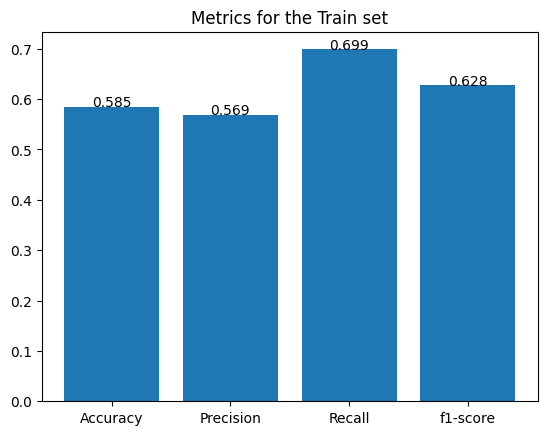

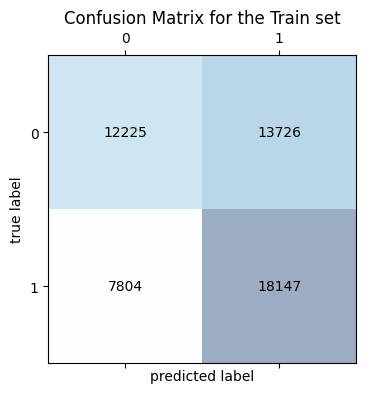

In [28]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

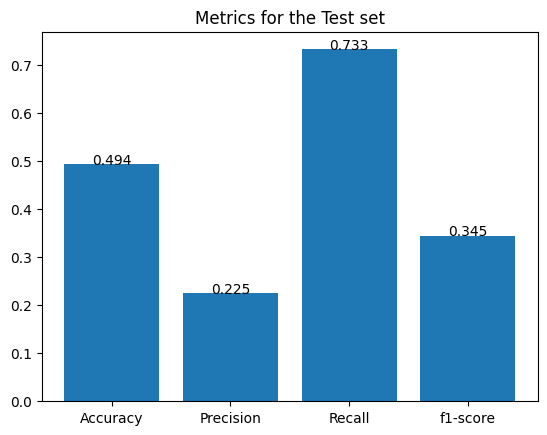

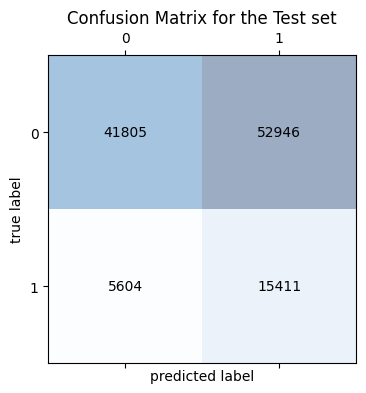

In [29]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

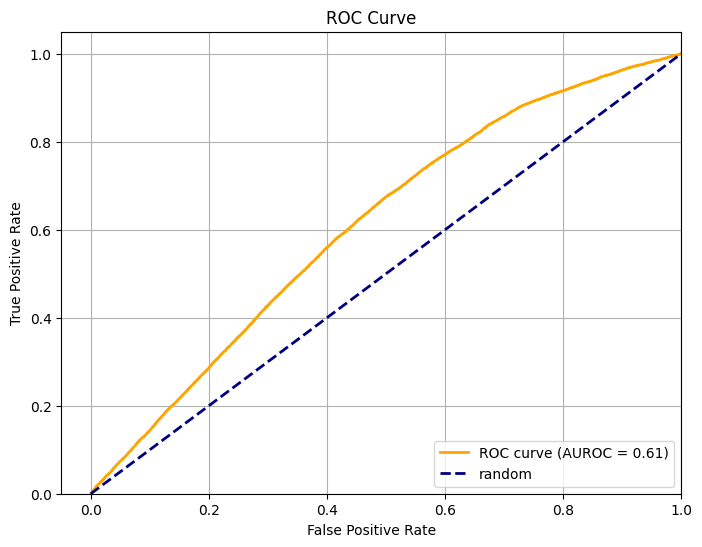

In [30]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [31]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.22544874701932502)

In [32]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    display(problematic_departments)
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.2292523401088787, 'Black': 0.2318574796960964, 'Asian': 0.19709462112288967, 'Mixed': 0.25193199381761977, 'Other': 0.19357195032870708}
Num problematic departments: 24
Num good departments: 9
avg diff: 0.11817848664202431


[('hampshire',
  0.06192928434911871,
  {'White': 0.3256319652079369,
   'Black': 0.26895306859205775,
   'Asian': 0.29118773946360155,
   'Other': 0.33088235294117646}),
 ('devon-and-cornwall',
  0.15503875968992245,
  {'White': 0.20269168026101142,
   'Black': 0.17829457364341086,
   'Asian': 0.19047619047619047,
   'Other': 0.3333333333333333}),
 ('suffolk',
  0.06552538370720187,
  {'White': 0.21185770750988142,
   'Black': 0.1487603305785124,
   'Asian': 0.18181818181818182,
   'Mixed': 0.21428571428571427,
   'Other': 0.21212121212121213}),
 ('merseyside',
  0.09951159951159952,
  {'White': 0.19722497522299307,
   'Black': 0.1623931623931624,
   'Asian': 0.22058823529411764,
   'Other': 0.2619047619047619}),
 ('thames-valley',
  0.07378078872986674,
  {'White': 0.21457581227436823,
   'Black': 0.22113821138211381,
   'Asian': 0.18428372739916551,
   'Other': 0.25806451612903225}),
 ('kent',
  0.09174707895304743,
  {'White': 0.21472581638940233,
   'Black': 0.25125628140703515,
 

In [33]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.23185746221347303, 'Female': 0.18052542781393108, 'Other': 0.1282051282051282}
Num problematic departments: 24
Num good departments: 11
avg diff: 0.09267327442786849


In [34]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.23018719874453536, '10-17': 0.179390480073387, '18-24': 0.263881338821154, 'over 34': 0.1840075132488093, 'under 10': 0.11627906976744186}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.13513890558028427


# Hypothesis 4: Remove stations with highest avg difference from training data and Sensitive Features and Lat/Long

# Get the data

In [ ]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

#keep only stations with low bias

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [50]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']


    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [52]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation
0,0.333333,0.0,0.826087,0.666667,0.54514,0.55516,0.0
1,0.0,1.0,0.73913,1.0,0.484365,0.55516,0.0
2,0.333333,0.0,0.652174,0.333333,0.484365,0.55516,0.0
3,0.0,0.0,0.391304,0.333333,0.484365,0.55516,0.0
4,0.333333,0.0,0.73913,0.166667,0.54514,0.55516,0.0
...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.54514,0.55516,0.0
98770,0.0,1.0,0.565217,0.166667,0.484365,0.55516,0.0
98771,1.0,1.0,0.217391,0.333333,0.54514,0.55516,0.0
98772,1.0,1.0,0.695652,0.833333,0.484365,0.331967,0.0


# Predict

In [53]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

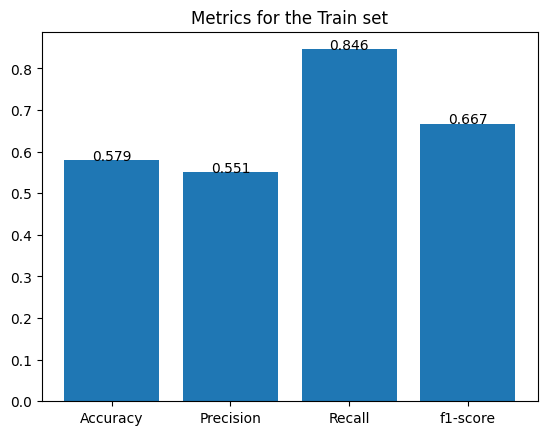

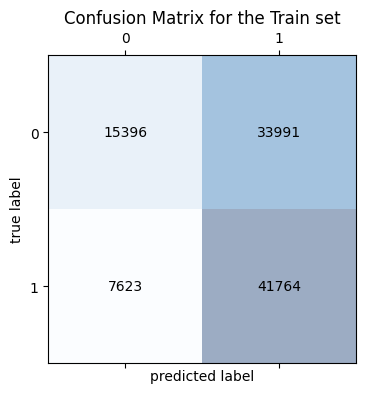

In [54]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

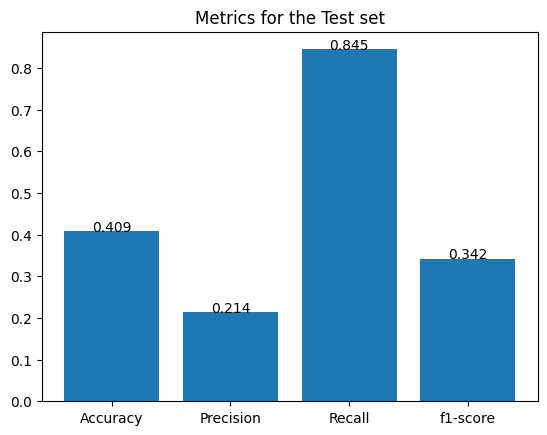

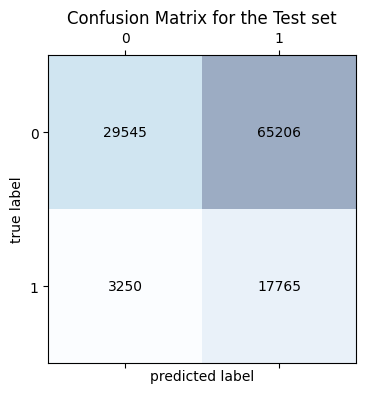

In [55]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

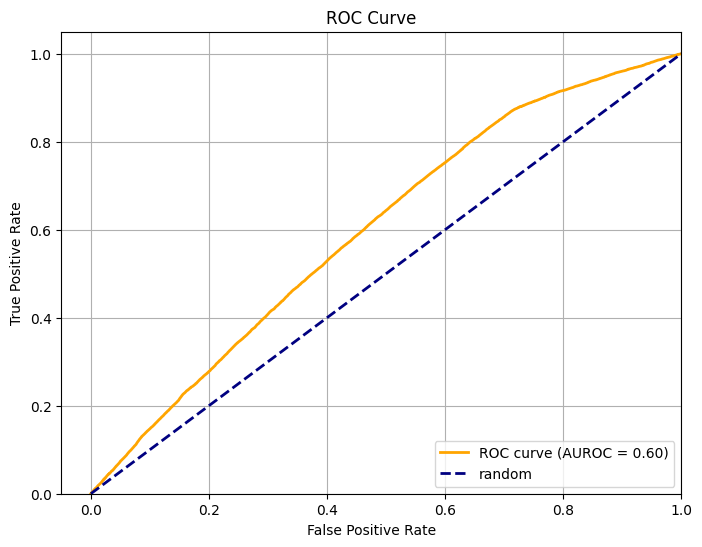

In [56]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [57]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.21411095442986103)

In [58]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    display(problematic_departments)
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.2165097527623658, 'Black': 0.22527996187753158, 'Asian': 0.18800368408933918, 'Mixed': 0.25, 'Other': 0.18718905472636815}
Num problematic departments: 24
Num good departments: 9
avg diff: 0.10724701389779605


[('hampshire',
  0.05145170983235803,
  {'White': 0.3221699418765569,
   'Black': 0.27071823204419887,
   'Asian': 0.288,
   'Other': 0.3111111111111111}),
 ('devon-and-cornwall',
  0.16689466484268128,
  {'White': 0.20198675496688742,
   'Black': 0.1875,
   'Asian': 0.18604651162790697,
   'Other': 0.35294117647058826}),
 ('north-wales',
  0.0650205058099795,
  {'White': 0.1900205058099795, 'Other': 0.125}),
 ('sussex',
  0.05085622342259513,
  {'White': 0.2781289506953224,
   'Black': 0.23222748815165878,
   'Asian': 0.24299065420560748,
   'Other': 0.22727272727272727}),
 ('suffolk',
  0.0796164139161463,
  {'White': 0.21334431630971992,
   'Black': 0.1440677966101695,
   'Asian': 0.2,
   'Mixed': 0.2236842105263158,
   'Other': 0.21875}),
 ('thames-valley',
  0.06622746185852982,
  {'White': 0.2133273703041145,
   'Black': 0.21937550040032025,
   'Asian': 0.18377253814147018,
   'Other': 0.25}),
 ('kent',
  0.08859206336879707,
  {'White': 0.2158227848101266,
   'Black': 0.24810126

In [59]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.21969311222734467, 'Female': 0.1752313447529041, 'Other': 0.14189189189189189}
Num problematic departments: 20
Num good departments: 15
avg diff: 0.08676350830350803


In [60]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.22083546779676805, '10-17': 0.16759683465222824, '18-24': 0.25446577908610424, 'over 34': 0.17389747262867083, 'under 10': 0.09433962264150944}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.1306033882049941
